=== 총 Entity 개수: 16 ===
{'Animal': 0, 'Cat': 1, 'Dog': 2, 'Flower': 3, 'Human': 4, 'Living Thing': 5, 'Lizard': 6, 'Mammal': 7, 'Oak': 8, 'Pine': 9, 'Plant': 10, 'Reptile': 11, 'Rose': 12, 'Snake': 13, 'Tree': 14, 'Tulip': 15}

=== 생성된 학습 데이터 (Triples) ===
       Head Relation          Tail
0    Animal      IsA  Living Thing
1     Plant      IsA  Living Thing
2    Mammal      IsA        Animal
3   Reptile      IsA        Animal
4    Flower      IsA         Plant
5      Tree      IsA         Plant
6       Dog      IsA        Mammal
7       Cat      IsA        Mammal
8     Human      IsA        Mammal
9     Snake      IsA       Reptile
10   Lizard      IsA       Reptile
11     Rose      IsA        Flower
12    Tulip      IsA        Flower
13     Pine      IsA          Tree
14      Oak      IsA          Tree


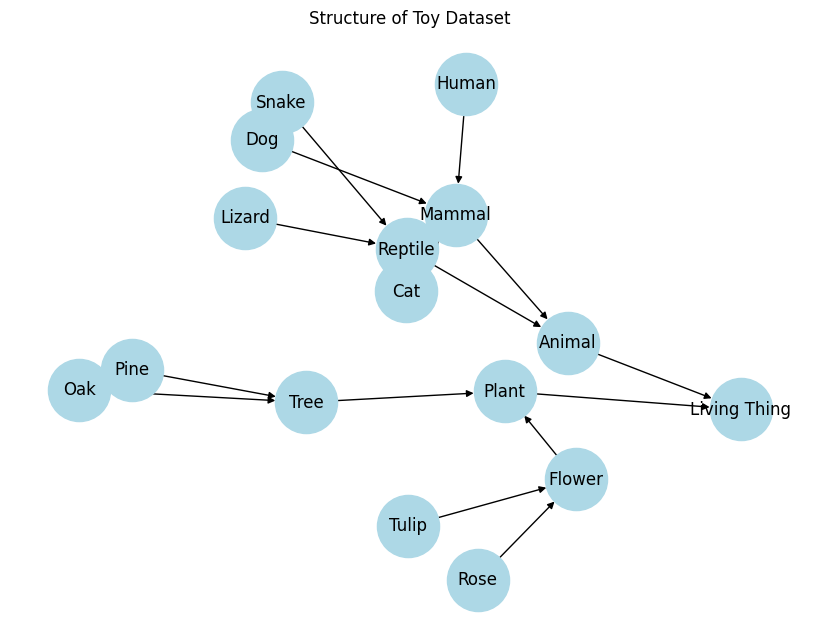

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def generate_toy_hierarchy():
    """
    3단계 깊이의 계층 구조 데이터를 생성합니다.
    Level 0: Living Thing (생물)
    Level 1: Animal, Plant (동물, 식물)
    Level 2: Mammal, Reptile, Flower, Tree (포유류, 파충류 등)
    Level 3: Dog, Cat, Snake, Rose, Pine (구체적 대상)
    """
    
    # 1. 계층 구조 정의 (Parent -> Children)
    hierarchy = {
        'Living Thing': ['Animal', 'Plant'],
        
        'Animal': ['Mammal', 'Reptile'],
        'Plant': ['Flower', 'Tree'],
        
        'Mammal': ['Dog', 'Cat', 'Human'],
        'Reptile': ['Snake', 'Lizard'],
        'Flower': ['Rose', 'Tulip'],
        'Tree': ['Pine', 'Oak']
    }

    triples = []
    
    # 2. Triple 생성 (Child, IsA, Parent)
    # Box Embedding에서는 보통 (Head, Relation, Tail)을 사용
    # 여기서는 "Child는 Parent의 부분집합이다"를 표현
    for parent, children in hierarchy.items():
        for child in children:
            # (Subject, Relation, Object)
            triples.append((child, 'IsA', parent))
            
            # Transitive Data (선택 사항): 
            # 학습을 돕기 위해 'Dog IsA Animal' 같은 건너뛰는 관계도 추가할 수 있음
            # 하지만 Box Embedding의 강력함을 보려면, 직접적인 관계만 주고
            # 건너뛰는 관계를 잘 추론하는지 보는 것이 좋음. (일단은 생략)

    return triples, hierarchy

# 데이터 생성 실행
toy_triples, toy_adj = generate_toy_hierarchy()

# 3. 데이터 확인 및 ID 매핑 (문자열 -> 숫자)
entities = sorted(list(set([t[0] for t in toy_triples] + [t[2] for t in toy_triples])))
entity2id = {e: i for i, e in enumerate(entities)}

print(f"=== 총 Entity 개수: {len(entities)} ===")
print(entity2id)
print("\n=== 생성된 학습 데이터 (Triples) ===")
df = pd.DataFrame(toy_triples, columns=['Head', 'Relation', 'Tail'])
print(df)

# 4. (참고용) 데이터 구조 시각화 (트리 구조 확인)
# 실제 Box 학습 전, 데이터가 어떻게 생겼는지 확인하는 용도
plt.figure(figsize=(8, 6))
G = nx.DiGraph()
G.add_edges_from([(t[0], t[2]) for t in toy_triples])
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, arrows=True)
plt.title("Structure of Toy Dataset")
plt.show()

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BoxEmbeddingModel(nn.Module):
    def __init__(self, num_entities, embedding_dim=2, volume_temp=1.0):
        super().__init__()
        
        self.num_entities = num_entities
        self.embedding_dim = embedding_dim
        self.volume_temp = volume_temp  # Gumbel-Softmax 등에 쓰이는 온도 상수 (여기선 단순화)

        # 1. Center Embedding (위치)
        # Center를 -3.0 ~ 3.0 정도로 넓게 퍼뜨림 (기존 -1~1)
        self.center_embeddings = nn.Embedding(num_entities, embedding_dim)
        nn.init.uniform_(self.center_embeddings.weight, -3.0, 3.0)

        # 2. Offset Embedding (크기/너비)
        # 중요: 박스 크기는 무조건 양수여야 함.
        # 초기화: 너무 작으면(0에 수렴) 점이 되고, 너무 크면 학습이 안 됨.
        # 0.1 ~ 0.5 사이의 값을 갖도록 초기화 유도
        self.offset_embeddings = nn.Embedding(num_entities, embedding_dim)
        nn.init.uniform_(self.offset_embeddings.weight, -2.0, -1.0)

    def get_boxes(self, indices):
        """
        Entity ID를 받아 [Min_coord, Max_coord]를 반환
        Min = Center - Offset
        Max = Center + Offset
        """
        centers = self.center_embeddings(indices)
        
        # Offset은 항상 양수여야 하므로 Softplus (Log(1+exp(x))) 통과
        # 그냥 abs()를 쓰면 0에서 미분 불가능 점이 생겨 학습이 불안정할 수 있음
        offsets = F.softplus(self.offset_embeddings(indices))
        
        min_coords = centers - offsets
        max_coords = centers + offsets
        
        return min_coords, max_coords, centers, offsets

    def forward(self, child_indices, parent_indices, lambda_vol=0.001): # lambda 추가
        c_min, c_max, _, c_offsets = self.get_boxes(child_indices)
        p_min, p_max, _, p_offsets = self.get_boxes(parent_indices)
        
        # --- Intersection Loss (L1 Norm 추천) ---
        # L2보다 힘이 일정해서 '교착 상태' 방지에 더 유리함
        violation_min = F.relu(p_min - c_min)
        violation_max = F.relu(c_max - p_max)
        
        # dim=-1은 그대로 두고, p=1로 변경
        intersection_loss = torch.norm(violation_min, p=1, dim=-1) + \
                            torch.norm(violation_max, p=1, dim=-1)
        
        # --- Volume Loss ---
        # 박스 크기(Offset)의 합
        vol_loss = torch.sum(c_offsets, dim=-1) + torch.sum(p_offsets, dim=-1)
        
        # 최종 Loss
        total_loss = intersection_loss.mean() + lambda_vol * vol_loss.mean()
        
        return total_loss

    def get_all_boxes_for_visualization(self):
        """시각화를 위해 모든 박스 좌표 반환 (Detach)"""
        with torch.no_grad():
            centers = self.center_embeddings.weight.data
            offsets = F.softplus(self.offset_embeddings.weight.data)
            
            min_coords = centers - offsets
            max_coords = centers + offsets
            
            return min_coords.cpu().numpy(), max_coords.cpu().numpy()

In [15]:
from collections import defaultdict, deque
toy_triples
def get_entity_levels(triples):
    """
    Triples를 분석하여 각 Entity의 깊이(Level)를 계산합니다.
    Root(부모가 없는 노드) = Level 0
    """
    # 1. 그래프 구성 (Adjacency List) 및 모든 노드 파악
    adj_list = defaultdict(list) # Parent -> Children
    all_entities = set()
    children = set() # 누군가의 자식인 노드들
    
    for child, relation, parent in triples:
        adj_list[parent].append(child)
        children.add(child)
        all_entities.add(child)
        all_entities.add(parent)
    
    # 2. Root 노드 찾기 (전체 집합 - 자식 집합)
    # 누군가의 자식이 아닌 노드가 곧 Root입니다.
    roots = list(all_entities - children)
    
    # 3. BFS(너비 우선 탐색)로 레벨 할당
    levels = {}
    queue = deque()
    
    # Root부터 시작 (Level 0)
    for root in roots:
        queue.append((root, 0))
        levels[root] = 0
    
    while queue:
        current_node, current_level = queue.popleft()
        
        # 자식들은 현재 레벨 + 1
        for child in adj_list[current_node]:
            # (주의) 이미 레벨이 매겨진 경우 건너뜀 (Cycle 방지)
            if child not in levels:
                levels[child] = current_level + 1
                queue.append((child, current_level + 1))
                
    return levels

get_entity_levels(toy_triples)

{'Living Thing': 0,
 'Animal': 1,
 'Plant': 1,
 'Mammal': 2,
 'Reptile': 2,
 'Flower': 2,
 'Tree': 2,
 'Dog': 3,
 'Cat': 3,
 'Human': 3,
 'Snake': 3,
 'Lizard': 3,
 'Rose': 3,
 'Tulip': 3,
 'Pine': 3,
 'Oak': 3}

In [24]:
for i in entity2id.keys():
    type(entity2id)
    break

In [ ]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imageio.v2 as imageio # GIF 생성을 위한 라이브러리
import os
import numpy as np

def train_and_visualize(model, triples, entity2id, epochs=500, lr=0.01, snapshot_interval=20):
    # 1. 데이터 준비 (Text -> Index 변환)
    # 학습 데이터는 (Child, Parent) 쌍으로 구성됩니다.
    # triples: [(Child, IsA, Parent), ...]
    child_indices = torch.tensor([entity2id[t[0]] for t in triples], dtype=torch.long)
    parent_indices = torch.tensor([entity2id[t[2]] for t in triples], dtype=torch.long)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # GIF 생성을 위한 이미지들을 저장할 리스트
    frames = []
    
    print("=== 학습 시작 ===")
    
    for epoch in range(1, epochs + 1):
        model.train() # 학습 모드
        optimizer.zero_grad() # 기울기 초기화
        
        # Forward Pass: Loss 계산
        loss = model(child_indices, parent_indices)
        
        # Backward Pass: 파라미터 업데이트
        loss.backward()
        optimizer.step()
        
        # --- 시각화 및 스냅샷 저장 로직 ---
        if epoch % snapshot_interval == 0 or epoch == 1:
            print(f"Epoch {epoch}/{epochs} | Loss: {loss.item():.4f}")
            
            # 1. 현재 박스 좌표 가져오기 (GPU -> CPU)
            min_coords, max_coords = model.get_all_boxes_for_visualization()
            
            # 2. 그림 그리기 (Matplotlib)
            fig, ax = plt.subplots(figsize=(8, 8))
            
            # 축 범위 고정 (박스가 움직이는 걸 잘 보려면 배경이 고정돼야 함)
            ax.set_xlim(-5.0, 5.0) # 2.0 -> 5.0으로 확대
            ax.set_ylim(-5.0, 5.0)
            ax.set_title(f"Box Embedding Training (Epoch {epoch})")
            ax.set_xlabel("Dimension 1")
            ax.set_ylabel("Dimension 2")
            ax.grid(True, linestyle='--', alpha=0.5)
            
            # 모든 Entity에 대해 박스 그리기
            for entity_name, idx in entity2id.items():
                # 해당 Entity의 좌표
                x_min, y_min = min_coords[idx]
                x_max, y_max = max_coords[idx]
                
                # 너비와 높이 계산
                width = x_max - x_min
                height = y_max - y_min
                
                # 색상 지정 (상위 개념일수록 크게/다르게 그리면 좋지만 일단 랜덤/고정)
                # 시각적 구분을 위해 Root(생물)는 빨강, 나머지는 파랑 등으로 할 수도 있음
                color = 'red' if entity_name == 'Living Thing' else 'blue'
                fill = False # 채우기 없음 (선만 그림)
                
                # 사각형 객체 생성
                rect = patches.Rectangle(
                    (x_min, y_min), width, height, 
                    linewidth=2, edgecolor=color, facecolor='none', alpha=0.7
                )
                ax.add_patch(rect)
                
                # 텍스트 라벨 (박스 중앙에 이름 표시)
                ax.text(
                    (x_min + x_max)/2, (y_min + y_max)/2, 
                    entity_name, 
                    fontsize=9, ha='center', va='center', color='black', weight='bold'
                )
            
            # 3. 그림을 메모리에 저장 (파일로 안 쓰고 버퍼 이용)
            # Matplotlib 그림을 Numpy 배열로 변환하여 frames 리스트에 추가
            fig.canvas.draw()

            # [수정됨] tostring_rgb() -> buffer_rgba() 사용
            # buffer_rgba()는 (Height, Width, 4) 형태의 RGBA 배열을 반환합니다.
            image_from_plot = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8) 

            # reshape: (Height, Width, 4) -> RGBA 채널 포함
            w, h = fig.canvas.get_width_height()
            image_from_plot = image_from_plot.reshape((h, w, 4))
            
            # GIF 용량 절약 및 호환성을 위해 Alpha(투명도) 채널 제거하고 RGB만 남김
            image_from_plot = image_from_plot[:, :, :3]

            frames.append(image_from_plot)
            plt.close(fig) # 메모리 해제

    print("=== 학습 완료 ===")
    
    # 4. GIF 파일로 저장
    gif_path = "box_embedding_training.gif"
    imageio.mimsave(gif_path, frames, fps=20) # 초당 5프레임
    print(f"GIF 저장 완료: {gif_path}")
    
    return frames

# --- 실행 코드 ---
# 1. 모델 생성 (Entity 개수, 차원=2)
model = BoxEmbeddingModel(num_entities=len(entity2id), embedding_dim=2)

# 2. 학습 및 시각화 실행
# 학습률(lr)이나 에포크(epochs)는 상황에 따라 조절
frames = train_and_visualize(model, toy_triples, entity2id, epochs=250, lr=0.04, snapshot_interval=1)